# Sensorial fusion via QNNs: Virtualization of the network

In this notebook we want to present the methodology we have followed to reach a quantized neural network that combines the sensors readings from a artificial noise, estimating the concentration of two different gases. The dataset comes from the work of Fonollosa et al. available  on the [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/gas+sensor+array+under+dynamic+gas+mixtures).

## The dataset
It comes with two different datasets but in this notebook we are using only the one with the ethylene and methane mixture. The first step is to import and take a look to it.
>Warning, it takes a while 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

In [3]:
t, CH4, Eth = np.loadtxt('data/ethylene_methane.txt', skiprows=1, usecols=(0,1,2), unpack=True)
sens = np.loadtxt('data/ethylene_methane.txt', skiprows=1, usecols=(3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18))

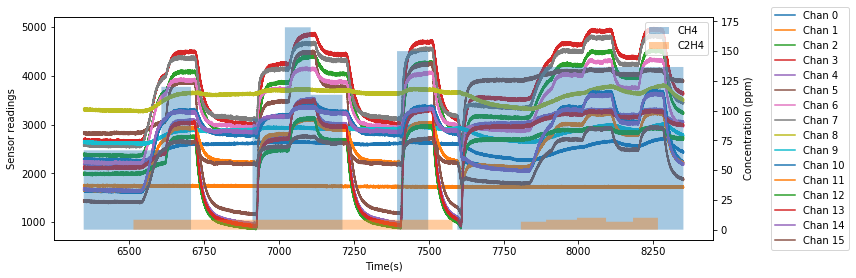

In [4]:
orig = 6350
fin = orig+2000

fig, ax1 = plt.subplots(figsize=(12.0,4.0))

ax2 = ax1.twinx()

ax2.set_ylabel('Concentration (ppm)') 
ax2.fill_between(t[np.logical_and(orig<t, t<fin)], CH4[np.logical_and(orig<t, t<fin)], alpha=0.4, label='CH4')
ax2.fill_between(t[np.logical_and(orig<t, t<fin)], Eth[np.logical_and(orig<t, t<fin)], alpha=0.4, label='C2H4')

ax1.set_xlabel('Time(s)')
ax1.set_ylabel('Sensor readings')
for i in range(16):
    ax1.plot(t[np.logical_and(orig<t, t<fin)], sens[np.logical_and(orig<t, t<fin),i], label='Chan '+str(i))
ax1.legend(loc='center left', bbox_to_anchor=(1.08, 0.5))
    
ax2.legend(loc='upper right')

fig.tight_layout()

fig.savefig('see-raw-data.png', dpi=600)

### Normalization
Typically any dataset that is going to be processed with neural networks needs to be normalized. We are going to do it with the following expression:
$\overline{x}=\frac{x-x_\min}{x_\max - x_\min}$

In [5]:
CH4max = CH4.max(); CH4min = CH4.min();
Ethmax = Eth.max(); Ethmin = Eth.min();
CH4norm = (CH4 - CH4min)/(CH4max - CH4min)
Ethnorm = (Eth - Ethmin)/(Ethmax - Ethmin)
sensnorm = np.empty(sens.shape)
for i in range(16):
    sensnorm[:,i] = (sens[:,i] - sens[:,i].min())/(sens[:,i].max() - sens[:,i].min())

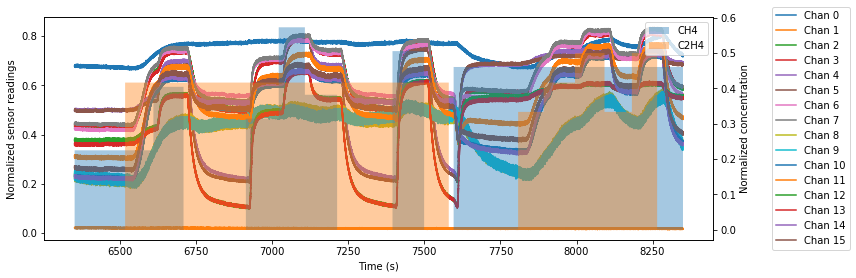

In [6]:
orig = 6350
fin = orig+2000

fig, ax1 = plt.subplots(figsize=(12.0,4.0))

ax2 = ax1.twinx()

ax2.set_ylabel('Normalized concentration') 
ax2.fill_between(t[np.logical_and(orig<t, t<fin)], CH4norm[np.logical_and(orig<t, t<fin)], alpha=0.4, label='CH4')
ax2.fill_between(t[np.logical_and(orig<t, t<fin)], Ethnorm[np.logical_and(orig<t, t<fin)], alpha=0.4, label='C2H4')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Normalized sensor readings')
for i in range(16):
    ax1.plot(t[np.logical_and(orig<t, t<fin)], sensnorm[np.logical_and(orig<t, t<fin),i], label='Chan '+str(i))
ax1.legend(loc='center left', bbox_to_anchor=(1.08, 0.5))
    
ax2.legend(loc='upper right')

fig.tight_layout()

fig.savefig('see-norm-data.png', dpi=600)

As you can see, the values for both the sensor readings and the concentration levels are now in the [0,1] range, but we still have a problem: there are a lot of sensor values for each combination of gas concentration levels. In order to get a manageable dataset for the neural model we are going to filter the data transforming it to a dataset of bijective relationships of the sensor readings and the gas concentrations instead of a time series with variable relationships.

### Filtering the sensor readings

Guided with the target of a biyective dataset, we start with the data filtering. The first thing we are doing is a sincronization, moving the sensor readings time series to the left until the maximun of sensor values in each constant concentration window match with the conceentration change.

In [7]:
Nsinc = -1000

In [8]:
senssinc = np.roll(sensnorm, Nsinc, axis=0)

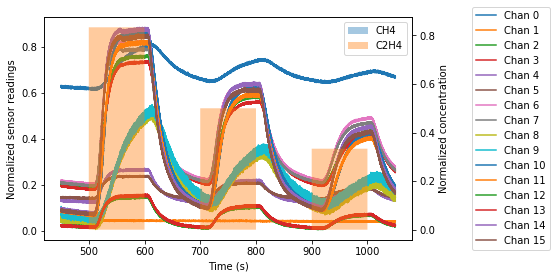

In [9]:
orig = 450
fin = 1050

fig, ax1 = plt.subplots(figsize=(8.0,4.0))

ax2 = ax1.twinx()

ax2.set_ylabel('Normalized concentration') 
ax2.fill_between(t[np.logical_and(orig<t, t<fin)], CH4norm[np.logical_and(orig<t, t<fin)], alpha=0.4, label='CH4')
ax2.fill_between(t[np.logical_and(orig<t, t<fin)], Ethnorm[np.logical_and(orig<t, t<fin)], alpha=0.4, label='C2H4')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Normalized sensor readings')
for i in range(16):
    ax1.plot(t[np.logical_and(orig<t, t<fin)], senssinc[np.logical_and(orig<t, t<fin),i], label='Chan '+str(i))
ax1.legend(loc='center left', bbox_to_anchor=(1.15, 0.5))
    
ax2.legend(loc='upper right')

fig.tight_layout()

fig.savefig('sincro.png')

Now we are ready to filter the data. We want to emulate the stationary response of the chemosensor, so we are going to do a window avarage in the left part (when it is cuasi-constant) of each sensor reading in each constant-concentration window.

In [10]:
Nflank = 0
Ndata = len(t)
tNew = []
PositFlank = []
CH4normNew = []
EthnormNew = []


for i in range(Ndata): #Primero barremos los tiempos
    if(CH4norm[i]!=CH4norm[i-1] or Ethnorm[i]!=Ethnorm[i-1]):
        Nflank += 1
        tNew.append(t[i])
        PositFlank.append(i)
        CH4normNew.append(CH4norm[i])
        EthnormNew.append(Ethnorm[i])

In [11]:
FraccAverage = 0.1
sensEstat = np.empty([Nflank,16])
for i in range(1,Nflank):
    for j in range(16):
        sensEstat[i-1,j] = np.mean(senssinc[(PositFlank[i-1]+int((1-FraccAverage)*(PositFlank[i]-PositFlank[i-1]))):PositFlank[i],j])

tNew = np.array(tNew)
CH4normNew = np.array(CH4normNew)
EthnormNew = np.array(EthnormNew)

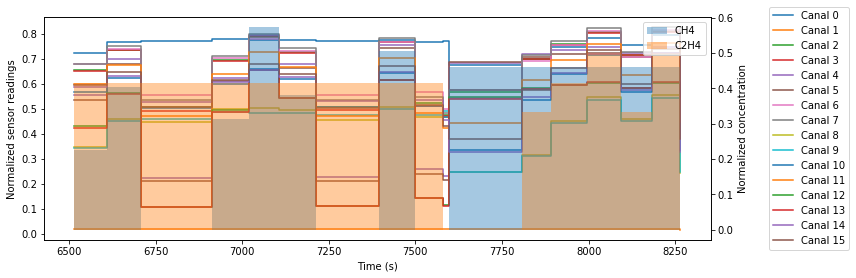

In [12]:
orig = 6350
fin = orig+2000

fig, ax1 = plt.subplots(figsize=(12.0,4.0))


ax2 = ax1.twinx()

ax2.set_ylabel('Normalized concentration') 
ax2.fill_between(tNew[np.logical_and(orig<tNew, tNew<fin)], CH4normNew[np.logical_and(orig<tNew, tNew<fin)], step='post', alpha=0.4, label='CH4')
ax2.fill_between(tNew[np.logical_and(orig<tNew, tNew<fin)], EthnormNew[np.logical_and(orig<tNew, tNew<fin)], step='post', alpha=0.4, label='C2H4')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Normalized sensor readings')
for i in range(16):
    ax1.step(tNew[np.logical_and(orig<tNew, tNew<fin)], sensEstat[np.logical_and(orig<tNew, tNew<fin),i], where='post', label='Canal '+str(i))
ax1.legend(loc='center left', bbox_to_anchor=(1.08, 0.5))
    
ax2.legend(loc='upper right')

fig.tight_layout()

fig.savefig('see-filtered-data.png', dpi=600)

As it is shown, now we have a bijective dataset. Let's save it.

In [13]:
np.savetxt('filtered-data/ethylene_methane.txt', np.column_stack([tNew[:len(tNew)-2], CH4normNew[:len(tNew)-2], EthnormNew[:len(tNew)-2], sensEstat[:len(tNew)-2,:]]), header='Time(s) CH4(norm) Eth(norm) filtered sensor readings (16 channels)')

In [14]:
t =tNew[:len(tNew)-2]
CH4 = CH4normNew[:len(tNew)-2]
Eth = EthnormNew[:len(tNew)-2]
sens = sensEstat[:len(tNew)-2,:]

In [15]:
t, CH4, Eth = np.loadtxt('filtered-data/ethylene_methane.txt', skiprows=1, usecols=(0,1,2), unpack=True)
sens = np.loadtxt('filtered-data/ethylene_methane.txt', skiprows=1, usecols=(3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18))
CH4max, CH4min, Ethmax, Ethmin = 296.67, 0.0, 20.0, 0.0

Before we start with the neural model, we are going to create the data loaders for this dataset. First we split the dataset into two, one big part (70%) as training set and the other as validation set

In [16]:
import torch

In [17]:
TS_VS_factor = 0.7
tTS, tVS = np.split(t, [int(TS_VS_factor*len(t))])
CH4TS, CH4VS = np.split(CH4, [int(TS_VS_factor*len(t))])
EthTS, EthVS = np.split(Eth, [int(TS_VS_factor*len(t))])
sensTS, sensVS = np.split(sens, [int(TS_VS_factor*len(t))])

In [18]:
gasTS = np.stack([CH4TS, EthTS])
gasTS = np.transpose(gasTS)

gasVS = np.stack([CH4VS, EthVS])
gasVS = np.transpose(gasVS)

In [19]:
sensTS = torch.tensor(sensTS, dtype=torch.float)
gasTS = torch.tensor(gasTS, dtype=torch.float)
train_ds = torch.utils.data.TensorDataset(sensTS, gasTS)

sensVS = torch.tensor(sensVS, dtype=torch.float)
gasVS = torch.tensor(gasVS, dtype=torch.float)
valid_ds = torch.utils.data.TensorDataset(sensVS, gasVS)

Now we configure the batch size. This is configurable in order to limit the memory usage during the training.

In [20]:
bsTS = gasTS.shape[0]//2
bsVS = gasVS.shape[0]//1

And we are ready to initialize the data loaders

In [21]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bsTS, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bsVS)

## The neural network
### Network arquitecture
Once we have the dataloaders we are ready to setup the neural model. We start configuring the network arquitecture: a two hidden layer feed-forwad network with sigmoid as activation function in all layers.

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
D_in, H1, H2, D_out = 16, 32, 12, 2

In [24]:
class TwoHiddenLayerNet(torch.nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
      
        super(TwoHiddenLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        
        x = self.linear1(x)
        x = F.sigmoid(x)
        x = self.linear2(x)
        x = F.sigmoid(x)
        x = self.linear3(x)
        x = F.sigmoid(x)
        return x

# Inicializamos el modelo
model = TwoHiddenLayerNet(D_in, H1, H2, D_out)

### Training
#### First phase: Floating training
We are going to do two different trainings. In the frist one we are going with a regular training until we got a point next to the final learned model. 

It's necessary to define the training parameters (epochs and the learning rate), the method to compute the cost and the optmizer to compute the paramteres update in each training epoch.

In [25]:
epochs, learning_rate = 1e4, 1e-4

In [26]:
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Now we can start the first training stage

In [27]:
from IPython.display import display, clear_output
import time

In [28]:
t0 = time.time()

train_loss_data =[]
train_dl_len = len(train_dl)
valid_loss_data =[]
valid_dl_len = len(valid_dl)
for epoch in range(int(epochs)+1):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = criterion(pred, yb)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        train_loss = sum(criterion(model(xb), yb) for xb, yb in train_dl)/train_dl_len
        train_loss_data.append(train_loss)
        valid_loss = sum(criterion(model(xb), yb) for xb, yb in valid_dl)/valid_dl_len
        valid_loss_data.append(valid_loss)
        
        if epoch%100==0:
            clear_output(wait=True)
            display('Epoch: '+str(epoch)+', Train Loss: '+'{:05.3f}'.format(train_loss)+', Valid Loss: '+'{:05.3f}'.format(valid_loss) + ', Min Valid Loss: '+'{:05.3f}'.format(min(valid_loss_data)))
    
    last_epoch = epoch

print('Trainimg time: '+str(time.time()-t0))

'Epoch: 10000, Train Loss: 0.412, Valid Loss: 0.850, Min Valid Loss: 0.850'

Trainimg time: 136.27424097061157


Here is the validation and training sets's cost during the training

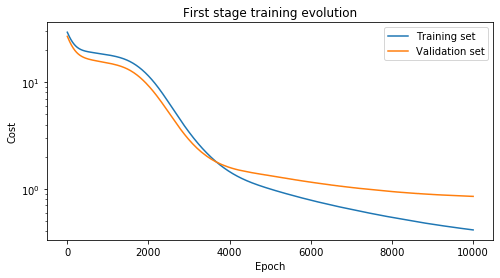

In [29]:
plt.figure(figsize=(8,4))
plt.semilogy(np.arange(last_epoch+1), train_loss_data, label='Training set')
plt.semilogy(np.arange(last_epoch+1), valid_loss_data, label= 'Validation set')
plt.title('First stage training evolution')
plt.ylabel('Cost')
plt.xlabel('Epoch');
plt.legend()

plt.savefig('EthCH4_training_VL'+str(valid_loss)+'.png', dpi=600)

Let's try the model

In [30]:
gaspred = model(torch.tensor(sens, dtype=torch.float))
CH4pred = gaspred[:,0]
Ethpred = gaspred[:,1]

model.eval();

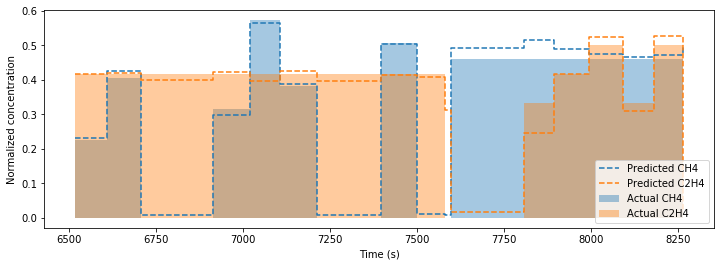

In [31]:
orig = 6350
fin = orig + 2000

with torch.no_grad():
    plt.figure(figsize=(12,4))

    plt.fill_between(t[np.logical_and(orig<t, t<fin)], CH4[np.logical_and(orig<t, t<fin)], alpha=0.4, step='post', label='Actual CH4')
    plt.fill_between(t[np.logical_and(orig<t, t<fin)], Eth[np.logical_and(orig<t, t<fin)], alpha=0.4, step='post', label='Actual C2H4')

    plt.step(t[np.logical_and(orig<t, t<fin)], CH4pred[np.logical_and(orig<t, t<fin)], 'C0--', where='post', label='Predicted CH4')
    plt.step(t[np.logical_and(orig<t, t<fin)], Ethpred[np.logical_and(orig<t, t<fin)], 'C1--', where='post', label='Predicted C2H4')
    
    plt.legend(loc='lower right')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized concentration')
    
    plt.savefig('see-results.png', dpi=600)

As we can see there are some errors, let's measure them. We are going to use the error respect to the range, with the following expression:
>$\varepsilon_i = \frac{y'_i-y_i}{y_{i_\max} - y_{i_\min}}\cdot 100$

where $y_i'$ is the model predicted concentration without normalization for the gas $i$, $y_i$ is its  actual concentration without normalization, $y_{i_\max}$ is its maximun value and $y_{i_\min}$ its minimum. 

Taking in account the normalization expression presented before, we are going to use this expression to compute the error:
> $\varepsilon_i = \frac{(\overline{y}'_i-\overline{y}_i)\cdot(y_{i_\max} - y_{i_\min})+y_{i_\min}}{y_{i_\max} - y_{i_\min}}\cdot 100$

with the $\overline{·}$ denoting normalized magnitudes

In [32]:
errCH4 = np.abs(((CH4pred.detach().numpy()-CH4)*(CH4max-CH4min)+CH4min)/(CH4max-CH4min))*100
errEth = np.abs(((Ethpred.detach().numpy()-Eth)*(Ethmax-Ethmin)+Ethmin)/(Ethmax-Ethmin))*100

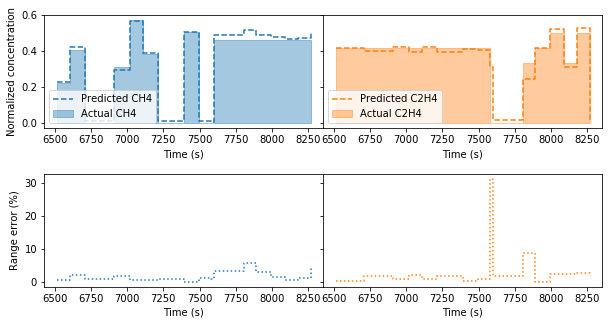

In [33]:
orig = 6350
fin = orig + 2000

with torch.no_grad():
    fig, axs = plt.subplots(nrows=2, ncols=2,  sharey='row', figsize=(10,5))

    axs[0,0].fill_between(t[np.logical_and(orig<t, t<fin)], CH4[np.logical_and(orig<t, t<fin)], color='C0', alpha=0.4, step='post', label='Actual CH4')
    axs[0,1].fill_between(t[np.logical_and(orig<t, t<fin)], Eth[np.logical_and(orig<t, t<fin)], color='C1', alpha=0.4, step='post', label='Actual C2H4')

    axs[0,0].step(t[np.logical_and(orig<t, t<fin)], CH4pred[np.logical_and(orig<t, t<fin)], 'C0--', where='post', label='Predicted CH4')
    axs[0,1].step(t[np.logical_and(orig<t, t<fin)], Ethpred[np.logical_and(orig<t, t<fin)], 'C1--', where='post', label='Predicted C2H4')
    
    #ax2.step(t[np.logical_and(orig<t, t<fin)], errTot[np.logical_and(orig<t, t<fin)], 'gray', where='post', label='Error total')
    axs[1,0].step(t[np.logical_and(orig<t, t<fin)], errCH4[np.logical_and(orig<t, t<fin)], 'C0:', where='post', label='CH4 error')
    axs[1,1].step(t[np.logical_and(orig<t, t<fin)], errEth[np.logical_and(orig<t, t<fin)], 'C1:', where='post', label='C2H4 error')
    
    
    for i in range(2): 
        for j in range(2): axs[i,j].set_xlabel('Time (s)')
    axs[0,0].set_ylabel('Normalized concentration')
    axs[1,0].set_ylabel('Range error (%)')
    
    axs[0,0].legend(loc='lower left')
    axs[0,1].legend(loc='lower left')
    
    fig.subplots_adjust(wspace=0, hspace=0.4)
    
    plt.savefig('first-stage.png', dpi=600)

In [34]:
torch.save(model.state_dict(), './EthCH4_VL'+str(valid_loss)+'_model.pth')

Once we got the first stage model parameters, we save them into a .txt file. We also save the model predictions along the entire time series, with the intention to compare it in the future.

In [35]:
fout = open("eth-ch4-params.txt","w")
for name, param in model.named_parameters():
    np.savetxt(fout, param.detach().numpy(), fmt='%.6f')
    #print(name, param)
fout.close()

In [36]:
orig = 0
fin = orig+100000
with torch.no_grad():
    np.savetxt('test-cpp/ethylene_methane_'+str(orig)+'-'+str(fin)+'.txt', np.column_stack([t[np.logical_and(orig<t, t<fin)],
                                                                           CH4[np.logical_and(orig<t, t<fin)],
                                                                           Eth[np.logical_and(orig<t, t<fin)],
                                                                           CH4pred[np.logical_and(orig<t, t<fin)],
                                                                           Ethpred[np.logical_and(orig<t, t<fin)],
                                                                           sens[np.logical_and(orig<t, t<fin),:]]),
               header='Time(s) CH4r(norm) Ethr(norm) CH4p(norm) Ethp(norm) filtered sensor readings (16 channels)')

This allow us to import it from C/C++ in Vivado HLS where we can run various simulations with different fixed point data types, whose results are in the next figure

![Fixed point representacion comparation](xohc.png)

where all fixed point lines were labeled as N-I, with N as the entire number of bits used in the data type and I the number of bits used in the integer part.

We decided to use the 12-3 fixed point representation due its closeness with the Pytorch prediction and its reduced number of bits with respect to the 32 bit flotating point representation

#### Second phase: Quantized training

In this stage we want to introduce the fixed point 12-3 representation in the weights, so at the end of this stage we'll have a 12-3 fixed point representable aprameters. First we code a function to quantize a torch tensor

In [37]:
from math import modf

def ToFixedTensor(TensorOrig, NbitsTot, NbitsInt):
    
    if len(TensorOrig.size())==2:
        rows, cols = TensorOrig.size()

        FixedTensor = torch.empty_like(TensorOrig)

        NbitsFrac = NbitsTot - NbitsInt

        for i in range(rows):
            for j in range(cols):
                FracOrig, IntOrig = modf(TensorOrig[i,j])

                IntOrig = int(IntOrig)

                MaxInt = 2**(NbitsInt - 1) - 1
                MinInt = -2**(NbitsInt - 1)

                if IntOrig > MaxInt: 
                    IntFixed = MaxInt
                elif IntOrig < MinInt:
                    IntFixed = MinInt
                else: IntFixed = IntOrig

                deltaFrac = 1/2**NbitsFrac 

                FracFixed = deltaFrac*round(FracOrig/deltaFrac)

                FixedTensor[i,j] =  IntFixed + FracFixed
    
    elif len(TensorOrig.size())==1:
        cols = TensorOrig.size()[0]

        FixedTensor = torch.empty_like(TensorOrig)

        NbitsFrac = NbitsTot - NbitsInt

        for i in range(cols):
            FracOrig, IntOrig = modf(TensorOrig[i])

            IntOrig = int(IntOrig)

            
            MaxInt = 2**(NbitsInt - 1) - 1
            MinInt = -2**(NbitsInt - 1)

            if IntOrig > MaxInt: 
                IntFixed = MaxInt
            elif IntOrig < MinInt:
                IntFixed = MinInt
            else: IntFixed = IntOrig

            deltaFrac = 1/2**NbitsFrac 

            FracFixed = deltaFrac*round(FracOrig/deltaFrac)

            FixedTensor[i] =  IntFixed + FracFixed
    else: raise ValueError('The tensor shape is incorret')
    return FixedTensor

def ToFixed(Orig, NbitsTot, NbitsInt):
   
    
    NbitsFrac = NbitsTot - NbitsInt
    
    FracOrig, IntOrig = modf(Orig)

    IntOrig = int(IntOrig)
    
    MaxInt = 2**(NbitsInt - 1) - 1 
    MinInt = -2**(NbitsInt - 1)

    if IntOrig > MaxInt: 
        IntFixed = MaxInt
    elif IntOrig < MinInt:
        IntFixed = MinInt
    else: IntFixed = IntOrig    

    deltaFrac = 1/2**NbitsFrac 

    FracFixed = deltaFrac*round(FracOrig/deltaFrac)
    
    return IntFixed + FracFixed

Now we start the second training, quantizing every 100 epochs

In [38]:
epochs = 5e3

In [39]:
t0 = time.time()

train_loss_data =[]
train_dl_len = len(train_dl)
valid_loss_data =[]
valid_dl_len = len(valid_dl)

for epoch in range(int(epochs)+1):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = criterion(pred, yb)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        train_loss = sum(criterion(model(xb), yb) for xb, yb in train_dl)/train_dl_len
        train_loss_data.append(train_loss)
        valid_loss = sum(criterion(model(xb), yb) for xb, yb in valid_dl)/valid_dl_len
        valid_loss_data.append(valid_loss)
        
        if epoch%100==0:
            clear_output(wait=True)
            display('Epoch: '+str(epoch)+', Train Loss: '+'{:05.3f}'.format(train_loss)+', Valid Loss: '+'{:05.3f}'.format(valid_loss) + ', Min Valid Loss: '+'{:05.3f}'.format(min(valid_loss_data)))
        
        if epoch % 100 == 0: #Cada 100 iteracciones hacemos:
            for param in model.parameters():
                param.data = ToFixedTensor(param.data, 12, 3)
                
    last_epoch = epoch

print('Tiempo de entrenamiento: '+str(time.time()-t0))

'Epoch: 5000, Train Loss: 0.287, Valid Loss: 0.807, Min Valid Loss: 0.805'

Tiempo de entrenamiento: 71.16725754737854


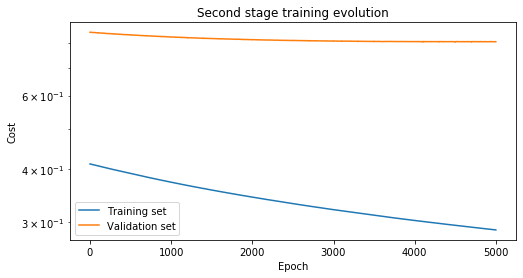

In [40]:
plt.figure(figsize=(8,4))
plt.semilogy(np.arange(last_epoch+1), train_loss_data, label='Training set')
plt.semilogy(np.arange(last_epoch+1), valid_loss_data, label= 'Validation set')
plt.title('Second stage training evolution')
plt.ylabel('Cost')
plt.xlabel('Epoch');
plt.legend()

plt.savefig('EthCH4_second_training_VL'+str(valid_loss)+'.png', dpi=600)

In [41]:
torch.save(model.state_dict(), './EthCH4Quant_VL'+str(valid_loss)+'_model.pth') #Guardamos el modelo

Let's see the results

In [42]:
model.eval()

gaspred = model(torch.tensor(sens, dtype=torch.float))
CH4pred = gaspred[:,0]
Ethpred = gaspred[:,1]

In [43]:
errCH4 = np.abs(((CH4pred.detach().numpy()-CH4)*(CH4max-CH4min)+CH4min)/(CH4max-CH4min))*100
errEth = np.abs(((Ethpred.detach().numpy()-Eth)*(Ethmax-Ethmin)+Ethmin)/(Ethmax-Ethmin))*100

errTot = np.sqrt(errCH4**2 + errEth**2) 

In [44]:
np.average(errCH4), np.average(errEth)

(1.6908884711479666, 2.2027718525764164)

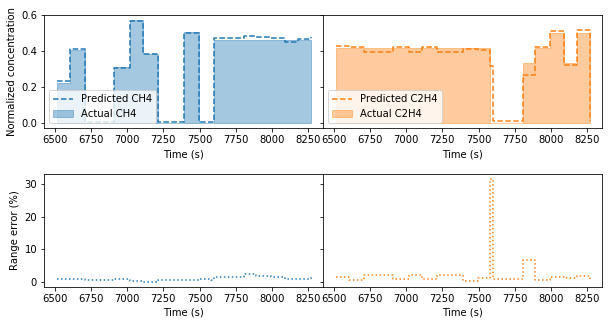

In [45]:
orig = 6350
fin = orig + 2000

with torch.no_grad():
    fig, axs = plt.subplots(nrows=2, ncols=2,  sharey='row', figsize=(10,5))

    axs[0,0].fill_between(t[np.logical_and(orig<t, t<fin)], CH4[np.logical_and(orig<t, t<fin)], color='C0', alpha=0.4, step='post', label='Actual CH4')
    axs[0,1].fill_between(t[np.logical_and(orig<t, t<fin)], Eth[np.logical_and(orig<t, t<fin)], color='C1', alpha=0.4, step='post', label='Actual C2H4')

    axs[0,0].step(t[np.logical_and(orig<t, t<fin)], CH4pred[np.logical_and(orig<t, t<fin)], 'C0--', where='post', label='Predicted CH4')
    axs[0,1].step(t[np.logical_and(orig<t, t<fin)], Ethpred[np.logical_and(orig<t, t<fin)], 'C1--', where='post', label='Predicted C2H4')
    
    #ax2.step(t[np.logical_and(orig<t, t<fin)], errTot[np.logical_and(orig<t, t<fin)], 'gray', where='post', label='Error total')
    axs[1,0].step(t[np.logical_and(orig<t, t<fin)], errCH4[np.logical_and(orig<t, t<fin)], 'C0:', where='post', label='CH4 error')
    axs[1,1].step(t[np.logical_and(orig<t, t<fin)], errEth[np.logical_and(orig<t, t<fin)], 'C1:', where='post', label='C2H4 error')
    
    
    for i in range(2): 
        for j in range(2): axs[i,j].set_xlabel('Time (s)')
    axs[0,0].set_ylabel('Normalized concentration')
    axs[1,0].set_ylabel('Range error (%)')
    
    axs[0,0].legend(loc='lower left')
    axs[0,1].legend(loc='lower left')
    
    fig.subplots_adjust(wspace=0, hspace=0.4)
    
    plt.savefig('see-quant-results.png', dpi=600)

In [46]:
fout = open("eth-ch4-params-quant.txt","w")
for name, param in model.named_parameters():
    np.savetxt(fout, param.detach().numpy(), fmt='%.6f')
    #print(name, param)
fout.close()

In [47]:
names= ['w01', 'b01', 'w12', 'b12', 'w23', 'b23']
i=0
for name, param in model.named_parameters():
    exec(names[i]+"= param.detach().numpy()")
    i+=1
np.savez("eth-ch4-params-quant.npz", w01=w01, b01=b01, w12=w12, b12=b12, w23=w23, b23=b23)

In [48]:
orig = 0
fin = orig+100000
with torch.no_grad():
    np.savetxt('test-cpp/ethylene_methane_qunat_'+str(orig)+'-'+str(fin)+'.txt', np.column_stack([t[np.logical_and(orig<t, t<fin)],
                                                                           CH4[np.logical_and(orig<t, t<fin)],
                                                                           Eth[np.logical_and(orig<t, t<fin)],
                                                                           CH4pred[np.logical_and(orig<t, t<fin)],
                                                                           Ethpred[np.logical_and(orig<t, t<fin)],
                                                                           sens[np.logical_and(orig<t, t<fin),:]]),
               header='Time(s) CH4r(norm) Ethr(norm) CH4p(norm) Ethp(norm) filtered sensor readings (16 channels)')

## Error analysis
The average error is around the 2%, but there are some spikes with more than 20% like the one between 7500 and 7750s.

In [49]:
errCH4ord = np.sort(errCH4)
errEthord = np.sort(errEth)

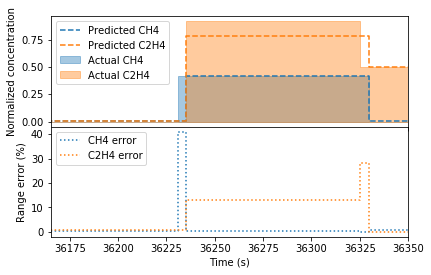

In [50]:
terrMaxCH4 = t[np.where(errCH4==errCH4ord[-1])]
terrMaxEth = t[np.where(errEth==errEthord[-1])]

anc = 500

chan=3

dcha = 500
izqda = 440

with torch.no_grad():
    fig, axs = plt.subplots(nrows=2,  sharex='col')

    axs[0].fill_between(t[np.logical_and(terrMaxCH4-izqda<t, t<terrMaxCH4+dcha)], CH4[np.logical_and(terrMaxCH4-izqda<t, t<terrMaxCH4+dcha)], color='C0', alpha=0.4, step='post', label='Actual CH4')
    axs[0].fill_between(t[np.logical_and(terrMaxCH4-izqda<t, t<terrMaxCH4+dcha)], Eth[np.logical_and(terrMaxCH4-izqda<t, t<terrMaxCH4+dcha)], color='C1', alpha=0.4, step='post', label='Actual C2H4')

    axs[0].step(t[np.logical_and(terrMaxCH4-izqda<t, t<terrMaxCH4+dcha)], CH4pred[np.logical_and(terrMaxCH4-izqda<t, t<terrMaxCH4+dcha)], 'C0--', where='post', label='Predicted CH4')
    axs[0].step(t[np.logical_and(terrMaxCH4-izqda<t, t<terrMaxCH4+anc)], Ethpred[np.logical_and(terrMaxCH4-izqda<t, t<terrMaxCH4+dcha)], 'C1--', where='post', label='Predicted C2H4')
    
    #ax2.step(t[np.logical_and(orig<t, t<fin)], errTot[np.logical_and(orig<t, t<fin)], 'gray', where='post', label='Error total')
    axs[1].step(t[np.logical_and(terrMaxCH4-izqda<t, t<terrMaxCH4+dcha)], errCH4[np.logical_and(terrMaxCH4-izqda<t, t<terrMaxCH4+dcha)], 'C0:', where='post', label='CH4 error')
    axs[1].step(t[np.logical_and(terrMaxCH4-izqda<t, t<terrMaxCH4+dcha)], errEth[np.logical_and(terrMaxCH4-izqda<t, t<terrMaxCH4+dcha)], 'C1:', where='post', label='C2H4 error')
    

    #axs[2].plot(treal[np.logical_and(terrMaxCH4-izqda<treal, treal<terrMaxCH4+dcha)], sensnorm[np.logical_and(terrMaxCH4-izqda<treal, treal<terrMaxCH4+dcha), chan-1], 'C2', label='Canal '+str(chan))
    #axs[2].step(t[np.logical_and(terrMaxCH4-izqda<t, t<terrMaxCH4+dcha)], sens[np.logical_and(terrMaxCH4-izqda<t, t<terrMaxCH4+dcha), chan-1], 'C3--', where='post', label='Canal '+str(chan)+' filtrado')
    
    #axs[0,0].step(t[np.logical_and(terrMaxCH4-anc<t, t<terrMaxCH4+anc)], sens[np.logical_and(terrMaxCH4-anc<t, t<terrMaxCH4+anc),7],'k',where='post')
    
    for i in range(2): 
        axs[i].margins(-0.4,0.05)
    axs[0].set_ylabel('Normalized concentration')
    axs[1].set_ylabel('Range error (%)')
    axs[1].set_xlabel('Time (s)')
    axs[0].legend(loc='upper left')
    axs[1].legend(loc='upper left')
    #axs[2].legend(loc='upper left')
    plt.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    
    fig.savefig('worst-error.png', dpi=600)


As you can see, this big errors are due to singularities in the dataset, with asynchronized changes in the concentration levels. This makes our filter to not properly work, thus blinding our neural model to this changes.

We plot all the errors in the next picture

In [51]:
CH4errsort=[]
Etherrsort=[]
for i in range(len(t)):
    CH4errsort.append(CH4[np.where(errCH4==errCH4ord[i])])
    Etherrsort.append(Eth[np.where(errEth==errEthord[i])])

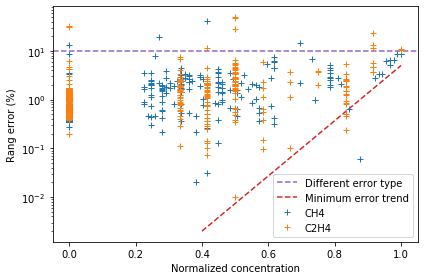

In [52]:
plt.axhline(y=10, label='Different error type', c='C4', ls='--')
plt.plot([0.4, 1],[2e-3, 5], 'C3--', label='Minimum error trend')

plt.semilogy(CH4errsort, errCH4ord, '+', label='CH4')
plt.semilogy(Etherrsort, errEthord, '+', label='C2H4')

plt.ylabel('Rang error (%)')
plt.xlabel('Normalized concentration')
plt.legend()
plt.tight_layout()

plt.savefig('errores.png', dpi=600)

Mainly, the errors bigger than the 10% are due to the singularities in the dataset. The others are because the quantized neural network inprecision. Also is remarkable the trend when the concentration gets higher, with the errors getting bigger. We relate this effect with the less poblation at high levels of concentration, giving less examples to train in the network.